# Rock-Paper-Scissors game implementation:

### Installing dependencies:

In [1]:
!pip install ultralytics roboflow js2py opencv-python matplotlib numpy PyQt6 mediapipe

Defaulting to user installation because normal site-packages is not writeable


### Importing dependencies

In [2]:
from IPython.display import display, Image
import requests
import cv2
import numpy as np
import PIL
import time
import sys
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
import logging
from PyQt6.QtWidgets import (
    QApplication,
    QLabel,
    QWidget,
    QVBoxLayout,
    QGridLayout,
    QPushButton,
)
from PyQt6.QtGui import QImage, QPixmap, QFont
from PyQt6.QtCore import QTimer, Qt
import mediapipe as mp
logging.getLogger('ultralytics').setLevel(logging.ERROR)
path = os.path.abspath(os.path.join(os.getcwd(), ''))
%matplotlib inline
%gui qt


### Loading the best weights of YOLOv8 model 

(trained in YOLOv8-Training.ipynb notebook)

In [3]:
model = YOLO(os.path.join(path, "best.pt") , verbose=False)  
model.verbose = False 

def yolov8_helper(img, width, height):
    """
    Helper function for YOLOv8 object detection.

    Params:
        img: Input image (NumPy array, BGR format).
        width: Width of the resized YOLO model input.
        height: Height of the resized YOLO model input.

    Returns:
        detections: List of detection results (label, confidence, bbox).
        width_ratio: Ratio of input image width to YOLO input width.
        height_ratio: Ratio of input image height to YOLO input height.
    """
    # Resize the image to YOLO input dimensions
    img_resized = cv2.resize(img, (width, height))

    # Run YOLOv8 detection
    results = model(img_resized)[0]

    # Get original image dimensions
    img_height, img_width, _ = img.shape
    width_ratio = img_width / width
    height_ratio = img_height / height

    # Parse results to match Darknet-style output
    detections = []
    for r in results.boxes:
        # Get bounding box coordinates
        x_min, y_min, x_max, y_max = map(int, r.xyxy[0])
        confidence = float(r.conf[0].item())  # Confidence score
        class_id = int(r.cls[0])  # Class ID
        label = results.names[class_id]  # Class name

        # Append detection in Darknet-style format
        detections.append((label, confidence, (x_min, y_min, x_max, y_max)))

    return detections, width_ratio, height_ratio

### YOLOv8 Example on Test Image
Let's make sure our model has successfully been loaded and we can make detections properly on a test image.

Image downloaded and saved!


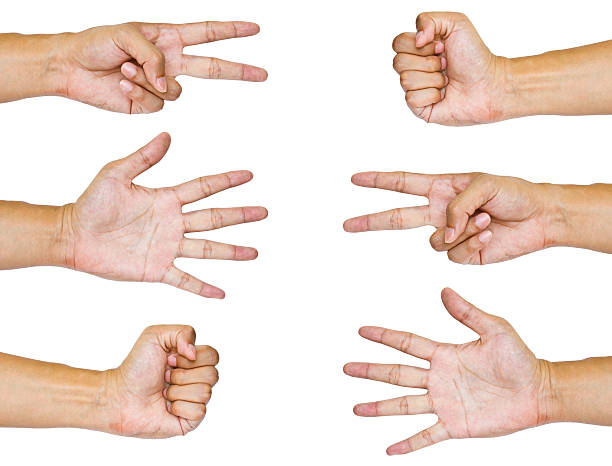

In [6]:
def download_image(url, filename):
    """downloads image and saves in filename using url"""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        
        print(f"Image downloaded and saved!")
        return filename  # Return the filename
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None

# Example usage
image_url = 'https://media.istockphoto.com/id/458909475/photo/hands-forming-paper-scissors-stone.jpg?s=612x612&w=0&k=20&c=ZRX61qvVtjDtR6FZmazYUaQ6WQ1zE6JGnhTZ1t9dFi8='  # Replace with your image URL
image_path = os.path.join(path, "sample.jpg") #Specify the desired path and filename
downloaded_image_path = download_image(image_url, image_path)

if downloaded_image_path:
    display(Image(filename=downloaded_image_path))

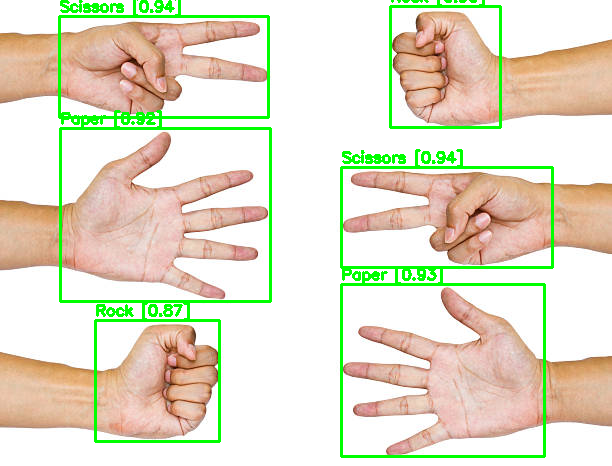

In [7]:
width = 640
height = 640

# Function to convert bounding box to points (left, top, right, bottom)
def bbox2points(bbox):
    x_min, y_min, x_max, y_max = bbox
    return int(x_min), int(y_min), int(x_max), int(y_max)

# Example image path (make sure the image exists at this location)
image = cv2.imread(os.path.join(path, "sample.jpg"))

# Run detection using YOLOv8 helper function
detections, width_ratio, height_ratio = yolov8_helper(image, width, height)

# Loop through detections and draw bounding boxes
for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    
    # Scale bounding box back to the original image size
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)

    # Draw bounding box and label
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)  # Green box
    cv2.putText(image, f"{label} [{confidence:.2f}]", (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with bounding boxes
PILOutput = PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
display(PILOutput)

### YOLOv8 on Webcam Videos
Running YOLOv8 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv8 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

YOLOv8 is so fast that it can run the detections in real-time!

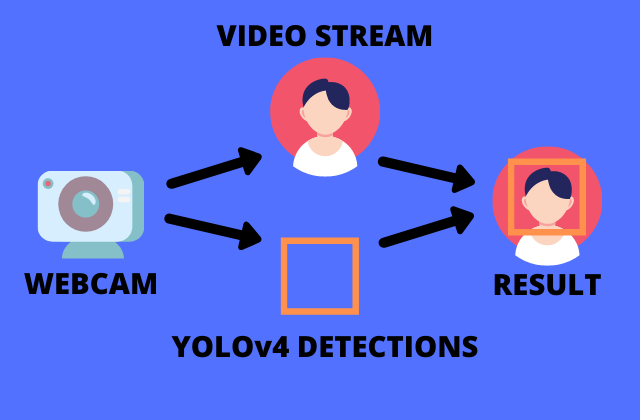

Below is a function to caputre frames as was used for images. The frames are fed as input to YOLOv8.

In [8]:
# Function to capture frames from the webcam
def capture_frame(cap):
    ret, frame = cap.read()

    if not ret:
        print("Failed to grab frame")
        return None
    
    return frame

### User class definition:

In [11]:
class User:
    """Base class for players"""
    def __init__(self, id, name, color, score):
        self.id = id
        self.name = name
        self.color = color
        self.score = score

    def add_score(self, score):
        self.score += score
        return self.score

    def Cheating(self):
        self.score -= 1

### Cheating detection implementation:

In [12]:
class CheatingDetector:
    def __init__(self):
        super().__init__()

    def detectMovementCheat(self, player1_boxes, player2_boxes, threshold=10.0):
        """
        Detects movement cheating by comparing the average movement of boxes for two users.
        So if players don't shake their hands enough during countdown, this function returns
        true for the cheater player.

        player1_boxes: List of bounding boxes for player 1.
        player2_boxes: List of bounding boxes for player 2.
        threshold: Threshold for movement difference.
        """
        
        def average_box_distance(boxes):
            """Calculate the average distance between consecutive boxes for a user."""

            if len(boxes) < 2:
                return 0.0  # No movement if only one box or empty
            
            total_distance = 0.0
            for i in range(len(boxes) - 1):
                center1 = ((boxes[i][0] + boxes[i][2]) / 2, (boxes[i][1] + boxes[i][3]) / 2)
                center2 = ((boxes[i + 1][0] + boxes[i + 1][2]) / 2, (boxes[i + 1][1] + boxes[i + 1][3]) / 2)
                total_distance += np.linalg.norm(np.array(center1) - np.array(center2))

            return total_distance / (len(boxes) - 1)

        avg_dist_player1 = average_box_distance(player1_boxes)
        avg_dist_player2 = average_box_distance(player2_boxes)

        # Return True if the average distance is less than the threshold
        return avg_dist_player1 < threshold, avg_dist_player2 < threshold

    
    def detectChangeCheat(self, player1_moves, player2_moves, num_moves, threshold=0.4):
        """
        Detects change cheating by counting significant number of various detections of model.
        Meaning if player changes their hand gesture after a meaningful amount of time after the
        game, this function can return true for the cheater.
        
        player1_moves: dict of player1 moves
        player2_moves: dict of player2 moves
        num_moves: number of moves
        threshold: threshold for cheating
        """

        player1_cheating = -1
        player2_cheating = -1

        player1_list = list(player1_moves.values())
        player2_list = list(player2_moves.values())

        player1_threshold = int(threshold * num_moves) - int(player1_list[-1] / 2)
        player2_threshold = int(threshold * num_moves) - int(player2_list[-1] / 2)

        player1_list = player1_list[:3]
        player2_list = player2_list[:3]

        for i in range(len(player1_list)):
            if player1_list[i] >= player1_threshold:
                player1_cheating += 1
            
            if player2_list[i] >= player2_threshold:
                player2_cheating += 1
        
        if player1_cheating > 0:
            player1_cheating = True
        
        else:
            player1_cheating = False
        
        if player2_cheating > 0:
            player2_cheating = True
        
        else:
            player2_cheating = False

        return player1_cheating, player2_cheating


### Assignment of scores to the players:

In [13]:
def give_points(player1_move, player2_move):
    """
    This function gives points to the players based on their moves.

    Parameters:
        player1_move (str): The move of player1
        player2_move (str): The move of player2
    """

    if player1_move == 'Rock':
        if player2_move == 'Scissors':
            # Player1 wins
            return 1
        
        if player2_move == 'Paper':
            # Player2 wins
            return 2
    
    if player1_move == 'Paper':
        if player2_move == 'Rock':
            # Player1 wins
            return 1
        
        if player2_move == 'Scissors':
            # Player2 wins
            return 2
    
    if player1_move == 'Scissors':
        if player2_move == 'Paper':
            # Player1 wins
            return 1
        
        if player2_move == 'Rock':
            # Player2 wins
            return 2
    
    # Draw
    return 0

### Helper functions for detecting left and right players:

In [14]:
def get_players_boxes(detections, width_ratio):

    """
    This function compares the detection boxes of the players hands and
    finds the left and the right players. This function is invoked when 
    there are at least two boxes are detected.
    """
    _, _, bbox1 = detections[0]
    left, _, _, _ = bbox2points(bbox1)
    left1 = int(left * width_ratio)

    _, _, bbox2 = detections[1]
    left, _, _, _ = bbox2points(bbox2)
    left2 = int(left * width_ratio)

    if left1 < left2:
        return detections[0], detections[1]

    else:
        return detections[1], detections[0]


def get_player_box(detection, width_ratio, size):
    """
    This function compares the detection box of the player with the center
    of the screen to find its location as 'left' or 'right'. This function
    is invoked when only one box is detected.
    """
    _, _, bbox1 = detection
    left, _, _, _ = bbox2points(bbox1)
    left1 = int(left * width_ratio)

    if left1 < size[1] / 2:
        return 'left'

    else:
        return 'right'

### Facial landmark detection (using mediapipe):

In [16]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=2)


def detect_face_landmarks(frame):
    """
    Detects facial landmarks using Mediapipe Face Mesh.
    Returns key points for precise mask placement.
    """

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        h, w, _ = frame.shape
        face_landmarks = []

        for face_landmark in results.multi_face_landmarks:
            landmarks = [
                (int(lm.x * w), int(lm.y * h)) for lm in face_landmark.landmark
            ]
            face_landmarks.append(landmarks)

        return face_landmarks

    return []


def sort_faces_by_position(face_landmarks):
    """
    Sorts detected faces from left to right using nose x-coordinate.
    Returns a list of tuples: (position_label, landmarks)
    """

    if not face_landmarks:
        return []

    # Sort faces based on the x-coordinate of the nose (index 1)
    sorted_faces = sorted(face_landmarks, key=lambda lm: lm[1][0])

    labeled_faces = []
    for i, landmarks in enumerate(sorted_faces):
        position = "Left Person" if i == 0 else "Right Person"
        labeled_faces.append((position, landmarks))

    return labeled_faces


I0000 00:00:1739102364.492541  295947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1739102364.496968  299025 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.3.2 - kisak-mesa PPA), renderer: AMD Radeon Vega 3 Graphics (radeonsi, raven2, LLVM 15.0.7, DRM 3.57, 6.8.0-51-generic)
W0000 00:00:1739102364.510578  299018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739102364.541332  299020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### Inserting mask on the cheater's face:

In [17]:
def apply_mask_using_landmarks(
    frame,
    face_landmarks,
    mask_img,
    target_person="Left Person",
    width_factor=1.5,
    height_factor=1.5,
    vertical_shift=0.2,
):
    """
    Overlays a mask image onto a specific detected face (Left or Right person) using facial landmarks.

    Parameters:
    - frame: The image/frame to process.
    - face_landmarks: List of detected face landmarks from Mediapipe.
    - mask_img: The mask image (must have transparency).
    - target_person: "Left Person" or "Right Person" to specify which face to apply the mask to.
    - width_factor: Controls the mask width scaling.
    - height_factor: Controls the mask height scaling.
    - vertical_shift: Moves the mask up or down.

    Returns:
    - frame: The frame with the mask applied (if conditions are met).
    """

    # Ensure we have at least two faces to distinguish left & right
    if len(face_landmarks) < 2:
        # print("Only one face detected, skipping mask placement.")
        return frame  # No mask is applied if only one face is detected.

    # Sort faces left to right
    sorted_faces = sort_faces_by_position(face_landmarks)

    # Find the selected face based on input
    selected_face = None
    for label, landmarks in sorted_faces:
        if label == target_person:
            selected_face = landmarks
            break

    if selected_face is None:
        # print(f"Could not find {target_person}, skipping mask placement.")
        return frame

    # Extract key facial landmarks for mask placement
    left_cheek = selected_face[234]
    right_cheek = selected_face[454]
    chin = selected_face[152]
    nose = selected_face[1]

    # Calculate dynamic width and height of the mask
    mask_width = int(abs(right_cheek[0] - left_cheek[0]) * width_factor)
    mask_height = int(abs(chin[1] - nose[1]) * width_factor * height_factor)

    # Determine mask position
    x1 = max(0, left_cheek[0] - (mask_width // 5) - 10)  # Move left by 20%
    y1 = max(0, nose[1] - int(mask_height * vertical_shift))  # Move mask upwards
    x2, y2 = min(frame.shape[1], x1 + mask_width), min(frame.shape[0], y1 + mask_height)

    # Resize the mask to fit the calculated dimensions
    mask_resized = cv2.resize(mask_img, (x2 - x1, y2 - y1))

    # Convert mask to RGBA if needed
    if mask_resized.shape[-1] != 4:
        mask_resized = cv2.cvtColor(mask_resized, cv2.COLOR_RGB2RGBA)

    # Extract alpha channel for blending
    alpha_mask = mask_resized[:, :, 3] / 255.0
    alpha_frame = 1.0 - alpha_mask

    # Blend the mask with the frame
    for c in range(3):
        frame[y1:y2, x1:x2, c] = (
            frame[y1:y2, x1:x2, c] * alpha_frame + mask_resized[:, :, c] * alpha_mask
        )

    return frame

mask_img = cv2.imread(
    os.path.join(path, "mask.png"), cv2.IMREAD_UNCHANGED
)  # Load with transparency


### Inserting crown on the winner's head and zooming:

In [18]:
def apply_crown_to_winner(
    frame,
    face_landmarks,
    crown_img,
    winner="Left Person",
    width_factor=2.0,
    height_factor=0.8,
    vertical_shift=-0.5,
):
    """
    Overlays a crown on the detected winner and zooms into their face.

    Parameters:
    - frame: The image/frame to process.
    - face_landmarks: List of detected face landmarks from Mediapipe.
    - crown_img: The crown image (must have transparency).
    - winner: "Left Person" or "Right Person" (who gets the crown).
    - width_factor: Controls the crown width scaling.
    - height_factor: Controls the crown height scaling.
    - vertical_shift: Moves the crown up or down.

    Returns:
    - zoomed_frame: The frame cropped and zoomed into the winner's face.
    """

    if len(face_landmarks) != 2:
        print("Not exactly two faces detected, skipping crown placement.")
        return frame  # Only apply if exactly two faces are detected.

    # Sort faces left to right
    sorted_faces = sort_faces_by_position(face_landmarks)

    # Find the selected winner
    selected_face = None
    for label, landmarks in sorted_faces:
        if label == winner:
            selected_face = landmarks
            break

    if selected_face is None:
        print(f"Could not find {winner}, skipping crown placement.")
        return frame

    # Extract key facial landmarks
    left_cheek = selected_face[234]
    right_cheek = selected_face[454]
    forehead = selected_face[
        10
    ]  # This landmark is above the eyes (good for placing the crown)

    # Calculate dynamic width and height of the crown
    crown_width = int(abs(right_cheek[0] - left_cheek[0]) * width_factor)
    crown_height = int(crown_width * height_factor)

    # Determine crown position
    x1 = max(0, forehead[0] - (crown_width // 2))
    y1 = max(0, forehead[1] - crown_height + int(crown_height * vertical_shift))
    x2, y2 = min(frame.shape[1], x1 + crown_width), min(
        frame.shape[0], y1 + crown_height
    )

    # Resize the crown image
    crown_resized = cv2.resize(crown_img, (x2 - x1, y2 - y1))

    # Convert crown to RGBA if needed
    if crown_resized.shape[-1] != 4:
        crown_resized = cv2.cvtColor(crown_resized, cv2.COLOR_RGB2RGBA)

    # Extract alpha channel for blending
    alpha_mask = crown_resized[:, :, 3] / 255.0
    alpha_frame = 1.0 - alpha_mask

    # Blend the crown with the frame
    for c in range(3):
        frame[y1:y2, x1:x2, c] = (
            frame[y1:y2, x1:x2, c] * alpha_frame + crown_resized[:, :, c] * alpha_mask
        )

    # ---- ZOOM INTO THE WINNER ----
    # Get bounding box around the winner's face
    x_min = min(left_cheek[0], right_cheek[0]) - 20
    x_max = max(left_cheek[0], right_cheek[0]) + 20
    y_min = min(left_cheek[1], right_cheek[1], forehead[1]) - 50
    y_max = max(left_cheek[1], right_cheek[1]) + 50

    # Expand the bounding box for a better zoom effect
    padding_x = int((x_max - x_min) * 0.5)  # Add extra space on sides
    padding_y = int((y_max - y_min) * 0.7)  # Add extra space on top & bottom

    # Define the zoom region
    x1 = max(0, x_min - padding_x)
    y1 = max(0, y_min - padding_y)
    x2 = min(frame.shape[1], x_max + padding_x)
    y2 = min(frame.shape[0], y_max + padding_y)

    # Crop and resize to simulate zoom
    zoomed_frame = frame[y1:y2, x1:x2]
    zoomed_frame = cv2.resize(
        zoomed_frame, (frame.shape[1], frame.shape[0])
    )  # Resize back to original size

    return zoomed_frame


crown_img = cv2.imread(
    os.path.join(path, "crown.png"), cv2.IMREAD_UNCHANGED
)  # Load with transparency

### Game Logic implementation:

In [19]:
class RockPaperScissorsGame(QWidget):
    def __init__(self, player1_name, player2_name, win_point, webcam_index=0):
        super().__init__()

        self.cap = cv2.VideoCapture(webcam_index)
        if not self.cap.isOpened():
            print("Error: Could not open webcam")
            sys.exit()

        self.player1 = User(id=1, name=player1_name, color="Red", score=0)
        self.player2 = User(id=2, name=player2_name, color="Blue", score=0)
        self.cheat_detector = CheatingDetector()
        self.cheaters = set()
        self.win_point = win_point
        self.game_state = "show_need_points"
        self.counter = 3
        self.start_frame_time = 0
        self.last_time = 0
        self.left_boxes = []
        self.right_boxes = []
        self.CheatedPlayers = []
        self.StartCheatingTime = 0
        self.StartWarningTime = 0
        self.UnAcceptableFrameCounter = 0
        self.winner = None

        self.initUI()

    def initUI(self):
        self.setWindowTitle("Rock Paper Scissors Game")
        self.setGeometry(200, 100, 900, 700)
        self.setStyleSheet(
            "background: qlineargradient(spread:pad, x1:0, y1:0, x2:1, y2:1, stop:0 #222, stop:1 #555);"
        )

        layout = QVBoxLayout()
        grid = QGridLayout()

        # self.video_label = QLabel(self)
        # self.video_label.setAlignment(Qt.AlignmentFlag.AlignCenter)
        # grid.addWidget(self.video_label, 0, 0, 1, 2)

        self.state_label = QLabel("Waiting for players...", self)
        self.state_label.setAlignment(Qt.AlignmentFlag.AlignCenter)
        self.state_label.setFont(QFont("Arial", 18, QFont.Weight.Bold))
        self.state_label.setStyleSheet("color: yellow;")
        grid.addWidget(self.state_label, 1, 0, 1, 2)

        self.score_label = QLabel(
            f"Scores - {self.player1.name}: {self.player1.score} | {self.player2.name}: {self.player2.score}",
            self,
        )
        self.score_label.setAlignment(Qt.AlignmentFlag.AlignCenter)
        self.score_label.setFont(QFont("Arial", 20, QFont.Weight.Bold))
        self.score_label.setStyleSheet(
            "color: white; background-color: #333; padding: 10px; border-radius: 10px;"
        )
        grid.addWidget(self.score_label, 2, 0, 1, 2)

        self.start_button = QPushButton("Start Game", self)
        self.start_button.setFont(QFont("Arial", 16, QFont.Weight.Bold))
        self.start_button.setStyleSheet(
            "background-color: #ff5733; color: white; padding: 10px; border-radius: 10px;"
        )
        self.start_button.clicked.connect(self.start_game)
        grid.addWidget(self.start_button, 3, 0, 1, 2)

        layout.addLayout(grid)
        self.setLayout(layout)

    def start_game(self):
        self.start_button.setEnabled(False)
        self.needed_point_counter = 3
        self.game_state = "show_need_points"
        self.player1.score = 0
        self.player2.score = 0
        self.last_needed_time = time.time()
        self.run_game_loop()  # Start processing frames

    def run_game_loop(self):
        while self.cap.isOpened():
            ret, frame = self.cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, (1080, 810))  # Resize frame for processing

            face_landmarks = detect_face_landmarks(frame)

            # Shows the mask only on the self.cheaters
            if face_landmarks:
                if "left" in self.cheaters:
                    frame = apply_mask_using_landmarks(
                        frame,
                        face_landmarks,
                        mask_img,
                        target_person="Left Person",
                        width_factor=1.9,
                        height_factor=2,
                        vertical_shift=0.7,
                    )
                if "right" in self.cheaters:
                    frame = apply_mask_using_landmarks(
                        frame,
                        face_landmarks,
                        mask_img,
                        target_person="Right Person",
                        width_factor=1.9,
                        height_factor=2,
                        vertical_shift=0.7,
                    )

            # Shows to crown if game_state == "end_game"
            if self.game_state == "end_game":
                which_side = 'left' if self.winner == self.player1.name else 'right'
                # no more cheat mask
                self.cheaters = set()
                frame = apply_crown_to_winner(
                    frame,
                    face_landmarks,
                    crown_img,
                    winner= "Left Person" if which_side == 'left' else "Right Person",
                    width_factor=2.0,
                    height_factor=0.8,
                    vertical_shift=0.2,
                )

            # Show OpenCV window to display the frame
            cv2.imshow("Webcam", frame)

            # Move the window to a specific location
            # cv2.moveWindow("Webcam", 700, 50)  # Move window to (x, y) position

            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

            self.process_game_logic(frame)

        self.close()

    def process_game_logic(self, frame):
        if self.game_state == "show_need_points":
            self.state_label.setText(f"First to {self.win_point} points wins!")
            self.state_label.setStyleSheet("color: yellow; font-size: 24px;")

            if time.time() - self.last_needed_time > 1:
                self.needed_point_counter -= 1
                self.last_needed_time = time.time()

            if self.needed_point_counter == 0:
                self.game_state = "show_ready_mode"
                self.state_label.setText("Please show Rock shape!")
                return

        elif self.game_state == "show_ready_mode":
            self.state_label.setText("Please show Rock shape!")
            self.state_label.setStyleSheet("color: yellow; font-size: 24px;")

            detections, _, _ = yolov8_helper(frame, width, height)

            if len(detections) != 2:
                self.state_label.setText("Please show Rock shape!")
                return

            label1, _, _ = detections[0]
            label2, _, _ = detections[1]

            if label1 == "Rock" and label2 == "Rock":
                self.state_label.setText("Get ready... Countdown starts!")
                self.last_time = time.time()
                self.counter = 3
                self.game_state = "show_countdown"
                self.left_boxes = []
                self.right_boxes = []

        elif self.game_state == "show_countdown":
            detections, width_ratio, _ = yolov8_helper(frame, width, height)
            print(detections)

            now_time = time.time()

            if now_time - self.last_time > 1:
                self.counter -= 1
                self.last_time = now_time

            self.state_label.setText(f"Countdown: {self.counter}")
            self.state_label.setStyleSheet("color: red; font-size: 28px;")

            if self.counter > 0:
                if len(detections) != 2:
                    self.UnAcceptableFrameCounter += 1
                    if self.UnAcceptableFrameCounter > 5:
                        self.StartWarningTime = time.time()
                        self.game_state = "warning_state"
                    return

                left_box, right_box = get_players_boxes(detections, width_ratio)

                if left_box[0] != "Rock" or right_box[0] != "Rock":
                    self.UnAcceptableFrameCounter += 1
                    if self.UnAcceptableFrameCounter > 5:
                        self.StartWarningTime = time.time()
                        self.game_state = "warning_state"
                    return
                self.UnAcceptableFrameCounter = 0
                self.left_boxes.append(left_box[2])
                self.right_boxes.append(right_box[2])

            if self.counter == 0:
                # Checking the game result
                self.state_label.setText("Checking the game result...")
                self.state_label.setStyleSheet("color: yellow; font-size: 24px;")

                player1_cheating, player2_cheating = (
                    self.cheat_detector.detectMovementCheat(
                        self.left_boxes, self.right_boxes
                    )
                )

                if player1_cheating:
                    self.cheaters.add("left")
                    self.player1.Cheating()
                    self.score_label.setText(
                        f"Scores - {self.player1.name}: {self.player1.score} | {self.player2.name}: {self.player2.score}"
                    )

                    self.CheatedPlayers.append(self.player1.name)
                    self.game_state = "cheating_detected"

                if player2_cheating:
                    self.cheaters.add("right")
                    self.player2.Cheating()
                    self.score_label.setText(
                        f"Scores - {self.player1.name}: {self.player1.score} | {self.player2.name}: {self.player2.score}"
                    )

                    self.CheatedPlayers.append(self.player2.name)
                    self.game_state = "cheating_detected"

                if player1_cheating or player2_cheating:
                    self.StartCheatingTime = time.time()
                    return

                self.state_label.setText("Game on! Don't Change your move!")
                self.state_label.setStyleSheet("color: green; font-size: 24px;")
                self.game_state = "game_mode"
                self.start_frame_time = time.time()
                self.player1_move = {"Rock": 0, "Paper": 0, "Scissors": 0, "None": 0}
                self.player2_move = {"Rock": 0, "Paper": 0, "Scissors": 0, "None": 0}
                self.num_moves = 0

        elif self.game_state == "warning_state":
            self.state_label.setText("Warning! Your Hand is not clear or not in Acceptable position")
            self.state_label.setStyleSheet("color: red; font-size: 24px;")
            if time.time() - self.StartWarningTime > 1:
                self.UnAcceptableFrameCounter = 0
                self.game_state = "show_ready_mode"

        elif self.game_state == "cheating_detected":
            Cheaters = ", ".join(self.CheatedPlayers)
            self.state_label.setText(
                f"Cheating detected! {Cheaters} is cheating! So Decrease 1 point"
            )
            self.state_label.setStyleSheet("color: red; font-size: 24px;")
            # if 2 seconds passed, then show_ready_mode
            if time.time() - self.StartCheatingTime > 2:
                self.CheatedPlayers = []
                self.game_state = "show_ready_mode"

        elif self.game_state == "game_mode":
            if time.time() - self.start_frame_time < 3:
                detections, width_ratio, _ = yolov8_helper(
                    frame, frame.shape[1], frame.shape[0]
                )

                self.num_moves += 1

                if len(detections) == 0:
                    self.player1_move["None"] += 1
                    self.player2_move["None"] += 1

                elif len(detections) == 1:
                    side = get_player_box(detections[0], width_ratio, frame.shape)

                    if side == "left":
                        self.player1_move[detections[0][0]] += 1

                    else:
                        self.player2_move[detections[0][0]] += 1

                elif len(detections) == 2:
                    left_box, right_box = get_players_boxes(detections, width_ratio)
                    self.player1_move[left_box[0]] += 1
                    self.player2_move[right_box[0]] += 1

            else:
                # Check if any player is cheating by changing their moves
                player1_cheating, player2_cheating = (
                    self.cheat_detector.detectChangeCheat(
                        self.player1_move, self.player2_move, self.num_moves
                    )
                )

                if player1_cheating:
                    self.cheaters.add("left")
                    self.player1.Cheating()
                    self.score_label.setText(
                        f"Scores - {self.player1.name}: {self.player1.score} | {self.player2.name}: {self.player2.score}"
                    )
                    self.CheatedPlayers.append(self.player1.name)
                    self.game_state = "cheating_detected"

                if player2_cheating:
                    self.cheaters.add("right")
                    self.player2.Cheating()
                    self.score_label.setText(
                        f"Scores - {self.player1.name}: {self.player1.score} | {self.player2.name}: {self.player2.score}"
                    )
                    self.CheatedPlayers.append(self.player2.name)
                    self.game_state = "cheating_detected"

                if player1_cheating or player2_cheating:
                    self.StartCheatingTime = time.time()
                    return

                move1 = max(self.player1_move, key=self.player1_move.get)
                move2 = max(self.player2_move, key=self.player2_move.get)
                which_player = give_points(move1, move2)

                if which_player == 1:
                    self.player1.add_score(1)

                elif which_player == 2:
                    self.player2.add_score(1)

                self.score_label.setText(
                    f"Scores - {self.player1.name}: {self.player1.score} | {self.player2.name}: {self.player2.score}"
                )

                if (
                    self.player1.score >= self.win_point
                    or self.player2.score >= self.win_point
                ):
                    self.game_state = "end_game"
                    return

                self.state_label.setText(f"Player {which_player} got the point!")
                self.game_state = "show_ready_mode"

        elif self.game_state == "end_game":
            self.winner = (
                self.player1.name
                if self.player1.score >= self.win_point
                else self.player2.name
            )

            self.state_label.setText(f"{self.winner} Wins!")
            self.state_label.setStyleSheet(
                "color: gold; font-size: 30px; background: black; padding: 10px;"
            )
            self.start_button.setEnabled(True)

    def closeEvent(self, event):
        self.cap.release()
        cv2.destroyAllWindows()
        event.accept()
        QApplication.quit()


try:
    app = QApplication.instance()
    if not app:
        app = QApplication([])
    # if camera is front camera, then the player1 is on the left side of the laptop
    player1 = "Sobhan"
    player2 = "Phone"
    window = RockPaperScissorsGame(player2, player1, 3, 0)
    window.show()
    app.exec()
    app.quit()

except Exception as e:
    print(e)
    sys.exit()

W0000 00:00:1739102642.962424  299019 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


[('Rock', 0.8787639737129211, (112, 368, 306, 632)), ('Rock', 0.845227837562561, (434, 335, 632, 610))]
[('Rock', 0.9123356342315674, (1, 369, 295, 638)), ('Rock', 0.8537944555282593, (449, 283, 639, 548))]
[('Rock', 0.8989644646644592, (458, 240, 638, 514)), ('Rock', 0.8859555125236511, (80, 276, 274, 536))]
[('Rock', 0.9058956503868103, (76, 209, 273, 461)), ('Rock', 0.8555817604064941, (458, 200, 638, 463))]
[('Rock', 0.8888766169548035, (82, 218, 275, 469)), ('Rock', 0.8794388175010681, (456, 215, 632, 467))]
[('Rock', 0.9045196175575256, (80, 227, 272, 476)), ('Rock', 0.8682518005371094, (452, 222, 636, 480))]
[('Rock', 0.9058020114898682, (76, 230, 272, 484)), ('Rock', 0.8497125506401062, (450, 225, 639, 487))]
[('Rock', 0.8893652558326721, (72, 235, 273, 488)), ('Rock', 0.828033447265625, (450, 230, 639, 489))]
[('Rock', 0.901952862739563, (77, 240, 271, 489)), ('Rock', 0.8524585962295532, (448, 233, 637, 495))]
[('Rock', 0.767689049243927, (0, 442, 183, 639)), ('Rock', 0.690903